# This is a spare jupyter notebook for testing new Methods

In [1]:
from hypermethyl import *
from utilities import *
import pickle
import matplotlib
import matplotlib.pyplot as plt
import random
import geom.hyperboloid as hyperboloid
import geom.poincare as poincare
import torch

In [2]:
def myrotate(T, root_coord, parent_coord, closest_coord):

    c = len(T)
    reflected = np.zeros((c, 2))
    ind = []
    k = 0
    for key, val in T.items():
        ind.append(key)
        reflected[k] = reflect_to_zero(root_coord, val) 
        k += 1
    
    p0 = reflect_to_zero(root_coord, parent_coord)
    q = norm(p0)
    p_angle = np.arccos(p0[0]/q)
    if p0[1] < 0:
        p_angle = 2*math.pi - p_angle
    
    c0 = reflect_to_zero(root_coord, closest_coord)
    q = norm(c0) 
    c_angle = np.arccos(c0[0]/q)
    
    if c0[1] < 0:
        c_angle = 2*math.pi - c_angle
    
    angle_dif = p_angle - c_angle
    for k in range(c):
        cur = reflected[k]
        q = norm(cur)
        cur_angle = np.arccos(cur[0]/q)
        if cur[1] < 0:
            cur_angle = 2*math.pi - cur_angle
        new_angle = cur_angle + angle_dif
        reflected[k] = [q * math.cos(new_angle), q * math.sin(new_angle)]
        T[ind[k]] = reflect_to_zero(root_coord, reflected[k]) 
    return T

In [13]:
def testembedding(X, node_positions, edges, tau=0.02, root=None):
    pg_size = len(node_positions)
    
    
    adj = [[] for i in range(pg_size)]
    
    deg = np.zeros(len(node_positions))
    for e1, e2 in edges:
        adj[e1].append(e2)
        adj[e2].append(e1)
        deg[e1] += 1
        deg[e2] += 1
    
    if root == None:
        root = find_root(adj)
        
    
    P = find_parent(adj, root)
    C = [[] for i in range(pg_size)]
    for i in range(pg_size):
        C[i] = [int(z) for z in adj[i] if not z == P[i]]
        
    
    closest_support = np.zeros((len(X), 2), dtype=np.float128)

    for i in range(len(X)):
        Z = [[metric(X[i], node_positions[j]), j] for j in range(len(node_positions))]
        closest_support[i] = min(Z)

    batch_nodes = [[] for i in range(pg_size)]
    for i in range(len(closest_support)):
        a, b = closest_support[i]
        batch_nodes[int(b)].append([i, a])
    
    G = np.zeros((pg_size, pg_size), dtype=np.float128)
    maxlength = 0
    for i in range(pg_size):
        for j in range(pg_size):
            G[i][j] = metric(node_positions[i], node_positions[j])
            maxlength = max(maxlength, G[i][j])
            
    print("Max degree: ", max(deg))
    print("Max Length: ", maxlength)
    
    subtree_size = [[] for i in range(pg_size)]
    subtree_size_dfs(batch_nodes, subtree_size, P, C, root)
    
    empty_segments = []
    for i in range(pg_size):
        if(len(batch_nodes[i]) == 0 and sum([len(batch_nodes[j]) for j in C[i]]) == 0):
            empty_segments.append(i)
    
    emb = do_hmds(node_positions, tau)
    print(len(emb), len(node_positions))
    #emb = hyp_embedding(G, root, tau, P, C)
    embX = np.zeros((len(X), 2), dtype=np.float128)
    
    for i in range(len(batch_nodes)):
        
        if(len(batch_nodes[i]) == 0):
            continue
        print("batch_size: ", len(batch_nodes[i]))
        if(len(batch_nodes[i]) == 1):
            embX[batch_nodes[i][0][0]] = emb[i]
            continue
        elif(len(batch_nodes[i]) > 100):
            max_local_dist = max([metric(X[j[0]], node_positions[i]) for j in batch_nodes[i]])
            sep_dist = np.array([metric(node_positions[i], node_positions[j]) for j in range(len(node_positions))])
            np.sort(sep_dist)
            for j in batch_nodes[i]:
                r_dist = random.random() * min(max_local_dist, sep_dist[3])
                r_angle = 2 * random.random() * math.pi



                tau_local = tau/(math.sqrt(len(X[0])))
                edge_length = r_dist * tau_local
                edge_length = hyptoeuc(edge_length)

                p = emb[P[i]]
                x = emb[i]

                p_coord = [edge_length * math.cos(r_angle), edge_length * math.sin(r_angle)]
                p_coord = reflect_to_zero(x, p_coord)
                embX[j[0]][0], embX[j[0]][1]  = p_coord[0], p_coord[1]
            continue
        else:
            convert_to = {}
            convert_back = {}
            counter = 0
            for a in batch_nodes[i]:
                if a[0] not in convert_to.keys():
                    convert_to[a[0]] = counter
                    convert_back[counter] = a[0]
                    counter += 1
            G = np.zeros((counter, counter))

            for a in batch_nodes[i]:
                for b in batch_nodes[i]:
                    G[convert_to[a[0]]][convert_to[b[0]]] = distance.euclidean(X[a[0]], X[b[0]])

            NJ = run(G)
            T = myadd_child2(NJ, 0, emb[i], tau/(math.sqrt(len(X[0]))))
            
            if(P[i] != -1):
                minkey = min([(metric(X[key], node_positions[i]), key) for key, val in T.items()])[1]
                closest_coord = T[minkey]
                not_included = None
                T = myrotate(T, emb[i], emb[P[i]], closest_coord)
            for ind, coord in T.items():
                if(np.isnan(coord).any()):
                    coord = emb[i]
                embX[convert_back[ind]] = coord

    return emb, embX, batch_nodes
def do_hmds(node_pos, tau):
    D_p = torch.tensor(pairwise_distances(node_pos, metric='minkowski')) * tau
    x_h = hyperboloid.mds(D_p, d = 2)
    p_h = hyperboloid.to_poincare(x_h).numpy()
    return p_h

In [3]:
data_dictionary = pickle.load(open("dnam/processed_immune.pkl", "rb" ))
methyl_data = data_dictionary['methylation']
labels = data_dictionary['disease']

In [4]:
methyl_data, labels, colors, dic = preprocess_data(methyl_data, labels)

All Labels: Mono, CD4T, CD8T, Erythroblast, WBC, NK, Gran/PMN, Bcell


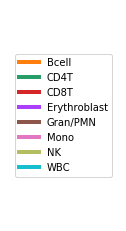

In [5]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
S = list(dic)
legend_elements = [Line2D([0], [0], color=dic[S[i]], lw=4, label=S[i]) for i in range(len(S))]

# Create the figure
fig, ax = plt.subplots(1, figsize=(2, 4))
plt.setp(ax, xticks=[], yticks=[])
ax.axis('off')
ax.legend(handles=legend_elements, loc='center')
#plt.show()

In [6]:
new_colors = ['#ff7f0e', '#17becf', '#c49c94', '#aa40fc', '#8c564b', '#ADD8E6', '#b5bd61', '#FFC0CB', '#aec7e8', '#ffbb78', '#FFFF00', '#ff9896', '#c5b0d5', '#c49c94']


i = 0
for key, val in dic.items():
    dic[key] = new_colors[i]
    i += 1

In [7]:
new_color = np.copy(colors)
for i in range(len(labels)):
    new_color[i] = dic[""+labels[i]]


In [8]:
X = PCA(n_components=50).fit_transform(methyl_data)

In [173]:
d = elastic_graph(X, n_clusters = 50, a = 1e-3)
edges = d['edges']
node_positions = d['node_positions']

In [174]:
emb, embX, batch_nodes = testembedding(X, node_positions, edges, tau = 0.05)

Max degree:  6.0
Max Length:  90.87643194763712984
50 50
batch_size:  28
batch_size:  1
batch_size:  2
batch_size:  16
batch_size:  4
batch_size:  3
batch_size:  2
batch_size:  3
batch_size:  13
batch_size:  6
batch_size:  1
batch_size:  2
batch_size:  2
batch_size:  43
batch_size:  12
batch_size:  18
batch_size:  12
batch_size:  13
batch_size:  22
batch_size:  16
batch_size:  23
batch_size:  15
batch_size:  25
batch_size:  10
batch_size:  22
batch_size:  9
batch_size:  26
batch_size:  17
batch_size:  10
batch_size:  14
batch_size:  9
batch_size:  12
batch_size:  13
batch_size:  22
batch_size:  8
batch_size:  9
batch_size:  1
batch_size:  3
batch_size:  12
batch_size:  9


In [131]:
print(embX)

[[-0.52872461 -0.51020861]
 [-0.53018565 -0.50669747]
 [-0.53126326 -0.5238707 ]
 [-0.27775916 -0.77548434]
 [-0.27783046 -0.77374568]
 [-0.52871474 -0.51965613]
 [-0.54101929 -0.50497452]
 [-0.27452615 -0.77452592]
 [-0.53673146 -0.5108375 ]
 [-0.53295268 -0.51958459]
 [-0.28101552 -0.77804098]
 [-0.28512951 -0.77206969]
 [-0.27382467 -0.77915228]
 [-0.53725338 -0.51662778]
 [-0.5394574  -0.5054451 ]
 [-0.52522753 -0.51735937]
 [-0.26167447 -0.78210085]
 [-0.27740627 -0.78249061]
 [-0.53765239 -0.51581504]
 [-0.52981136 -0.51318014]
 [-0.2721911  -0.77010589]
 [-0.52924524 -0.52175412]
 [-0.28696447 -0.77677721]
 [-0.27503078 -0.77943198]
 [-0.53487817 -0.51833985]
 [-0.32515759 -0.63670813]
 [-0.53942459 -0.51648305]
 [-0.53235085 -0.51991409]
 [-0.53570422 -0.50919857]
 [-0.28124372 -0.77949905]
 [-0.27790709 -0.78065671]
 [-0.52984324 -0.51297171]
 [-0.27446437 -0.77870946]
 [-0.54171334 -0.51733127]
 [-0.53496712 -0.51016059]
 [-0.2797591  -0.77819319]
 [-0.53420097 -0.51230584]
 

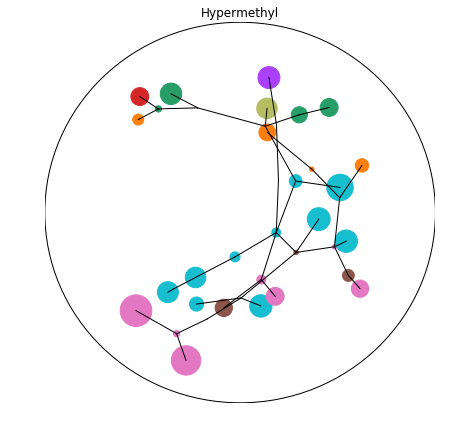

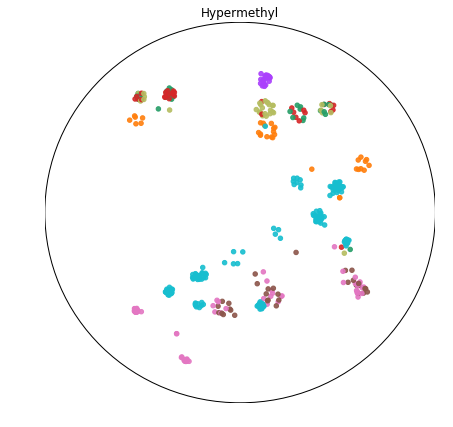

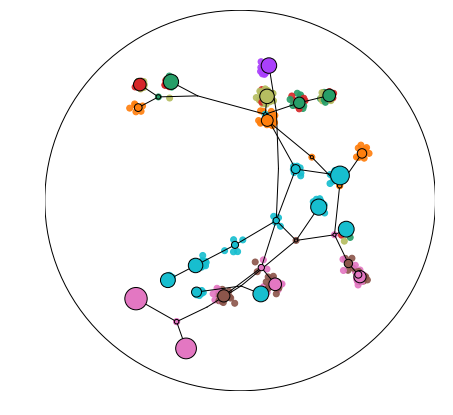

In [167]:
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
s = [20*len(batch_nodes[i]) for i in range(len(emb))]
big_col = ["white" for i in range(len(emb))]
for i in range(len(emb)):
    dic = {}
    for j in batch_nodes[i]:
        if(colors[j[0]] not in dic):
            dic[colors[j[0]]] = 0
        dic[colors[j[0]]] += 1
    maxkey = ""
    maxval = -1
    for key, val in dic.items():
        if(val > maxval):
            maxkey = key
            maxval = val
    if(maxkey != ""):
        big_col[i] = maxkey
plt.title("Hypermethyl")
        
plt.scatter(*emb.T, s=s, c = big_col)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()
for k in range(len(edges)):
    n0 = edges[k][0]
    n1 = edges[k][1]
    x_line = [ emb[n0][0],  emb[n1][0] ]
    y_line = [ emb[n0][1],  emb[n1][1] ]
    plt.plot(x_line, y_line, 'black', linewidth = 1)

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
plt.title("Hypermethyl")
plt.scatter(embX[:, 0], embX[:,1], s=20, cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
s = [10*len(batch_nodes[i]) for i in range(len(emb))]
big_col = ["white" for i in range(len(emb))]
for i in range(len(emb)):
    dic_node = {}
    for j in batch_nodes[i]:
        if(colors[j[0]] not in dic_node):
            dic_node[colors[j[0]]] = 0
        dic_node[colors[j[0]]] += 1
    maxkey = ""
    maxval = -1
    for key, val in dic_node.items():
        if(val > maxval):
            maxkey = key
            maxval = val
    if(maxkey != ""):
        big_col[i] = maxkey
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))

for k in range(len(edges)):
    n0 = edges[k][0]
    n1 = edges[k][1]
    x_line = [ emb[n0][0],  emb[n1][0] ]
    y_line = [ emb[n0][1],  emb[n1][1] ]
    plt.plot(x_line, y_line, 'black', linewidth = 1, zorder = 1)
plt.scatter(embX[:, 0], embX[:,1], cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.scatter(*emb.T, s=s, c = big_col, edgecolors='black', zorder=2)

In [144]:
p_x = do_hmds(X, 0.02)

[]

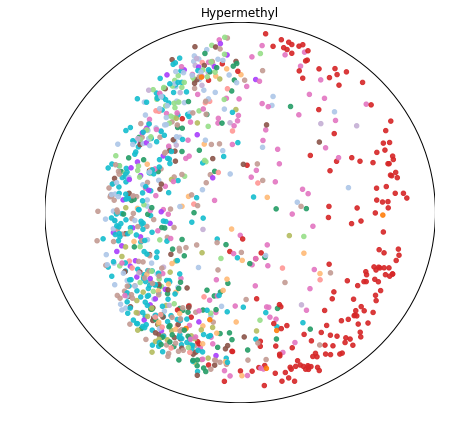

In [145]:
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
plt.title("Hypermethyl")
plt.scatter(*p_x.T, s=20, cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()

In [82]:
def hyperbolic(x, y):
    return math.acosh(1 + (2 * norm(x-y)**2 / ((1 - norm(x)**2)*(1 - norm(y)**2))))
def find_closest_nodes(x, pnodes, n):
    Z = [[hyperbolic(x, pnodes[j]), j] for j in range(len(pnodes))]
    Z.sort()
    return [Z[i][1] for i in range(n)]
def pdist(u, v):
    squnorm = torch.clamp(torch.sum(u * u, dim=-1), 0, 1 - 1e-8)
    sqvnorm = torch.clamp(torch.sum(v * v, dim=-1), 0, 1 - 1e-8)
    sqdist = torch.sum(torch.pow(u - v, 2), dim=-1)
    x = sqdist / ((1 - squnorm) * (1 - sqvnorm)) * 2 + 1
    z = torch.sqrt(torch.pow(x, 2) - 1 + 1e-16)
    return torch.log(x + z)
def eucdist(u, v):
    norm = torch.pow((u - v), 2)
    sumnorm = torch.sum(norm, dim = -1)
    return torch.sqrt(sumnorm)
def poincare_grad(p, d_p):
    p_sqnorm = torch.sum(p.data ** 2, dim=-1, keepdim=True)
    d_p = d_p * ((1 - p_sqnorm) ** 2 / 4).expand_as(d_p)
    return d_p
def create_prob(t):
    t_e = torch.exp(t)
    u_e = torch.clone(t_e)
    u_e /= torch.sum(t_e)
    return u_e
def lossfn(y_pred, og_dist):
    return torch.sum(torch.pow((y_pred - og_dist), 2))
    #return torch.sum(y_pred * torch.log(y_pred/og_dist) + (1-y_pred) * torch.log((1-y_pred)/(1-og_dist)))
def train2(x, y, u, v, clos_index, lr = 1e-3, epochs = 50, tau = 0.02, alpha = 1, beta = 1):
    #x = closest p_x in E NxBxD
    #y = closest p_x in P NxBx2
    #u = current points in P Nx2
    #v = current points in X NxD
    #clos_index = index of knn NxK
    #loss = loss function to knn + loss function to pnodes
    x = torch.tensor(x)
    y = torch.tensor(y)
    u = torch.tensor(u)
    v = torch.tensor(v)
    og_dist = [create_prob(eucdist(v[i], y[i]) * tau) for i in range(len(v))]
    og_dist = torch.stack(og_dist)
    u.requires_grad_()
    
    
    print("Orginal Distance:", og_dist)
    for t in range(epochs):
        
        y_pred = [create_prob(pdist(u[i], x[i])) for i in range(len(v))]
        y_pred = torch.stack(y_pred)
        e_knn = torch.tensor([[v[clos_index[i][j]].tolist() for j in range(len(clos_index[i]))] for i in range(len(clos_index))])
        p_knn = torch.tensor([[u[clos_index[i][j]].tolist() for j in range(len(clos_index[i]))] for i in range(len(clos_index))])
        e_dist = [torch.clone(eucdist(v[i], e_knn[i])) * 1e-10  for i in range(len(v))]
        e_dist = torch.stack(e_dist)
        p_dist = [pdist(u[i], p_knn[i]) for i in range(len(v))]
        p_dist = torch.stack(p_dist)
        
        distloss = alpha * lossfn(y_pred, og_dist)
        
        maploss = beta * lossfn(p_dist, e_dist)
        
        loss = distloss +  maploss
        if t % 5 == 0:
            print("distloss:", distloss)
            print("maploss:", maploss)
            print("loss", loss)
            print()
        loss.backward()
        with torch.no_grad():
            d_p = poincare_grad(u, u.grad)
            u -= lr * d_p
            u = torch.clamp(u, -1 + 1e-8, 1 - 1e-8)
            #print("u:", u)
            u.requires_grad_()
        u.grad = None

    return u.detach().numpy()


In [175]:
emb = emb.astype('float64')
embX = embX.astype('float64')
embeddings = embX

In [176]:
closest_pnode = []
closest_X = []
for index in range(len(X)):
    closest_index = find_closest_nodes(embX[index], emb, 5)
    closest_pnode.append([emb[i] for i in closest_index])
    closest_X.append([node_positions[i] for i in closest_index])
    
KNN = kneighbors_graph(X, 10, mode='distance', metric='minkowski', include_self=False).toarray()
closest_index_points = []
for i in range(len(X)):
    closest_index_points.append(np.nonzero(np.array(KNN[i]))[0])
closest_index_points = np.array(closest_index_points)
print(closest_index_points)
'''
for i in range(20):
    embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 0.003, epochs = 3, tau = tau, alpha = 100, beta = 1e-5)
    embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 1e-3, epochs = 3, tau = tau, alpha = 0.01, beta = 0.1)
'''
embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 1e-2, epochs = 50, tau = 0.05, alpha = 10, beta = 1e-1)


[[  2  18  36 ...  77  82  92]
 [  8   9  19 ...  65  70  78]
 [  0  18  27 ...  53  86  92]
 ...
 [476 477 479 ... 484 486 487]
 [476 477 478 ... 484 485 487]
 [476 477 479 ... 484 485 486]]
Orginal Distance: tensor([[0.0810, 0.1168, 0.0840, 0.4196, 0.2987],
        [0.0758, 0.0830, 0.3559, 0.1109, 0.3745],
        [0.0799, 0.1087, 0.0867, 0.4354, 0.2893],
        ...,
        [0.0266, 0.0736, 0.0491, 0.4883, 0.3624],
        [0.0259, 0.0743, 0.0456, 0.4658, 0.3885],
        [0.0243, 0.0640, 0.0440, 0.4850, 0.3827]], dtype=torch.float64)
distloss: tensor(193.7745, dtype=torch.float64, grad_fn=<MulBackward0>)
maploss: tensor(76.6160, dtype=torch.float64, grad_fn=<MulBackward0>)
loss tensor(270.3905, dtype=torch.float64, grad_fn=<AddBackward0>)

distloss: tensor(181.9872, dtype=torch.float64, grad_fn=<MulBackward0>)
maploss: tensor(66.1110, dtype=torch.float64, grad_fn=<MulBackward0>)
loss tensor(248.0982, dtype=torch.float64, grad_fn=<AddBackward0>)

distloss: tensor(175.0652, dtype=to

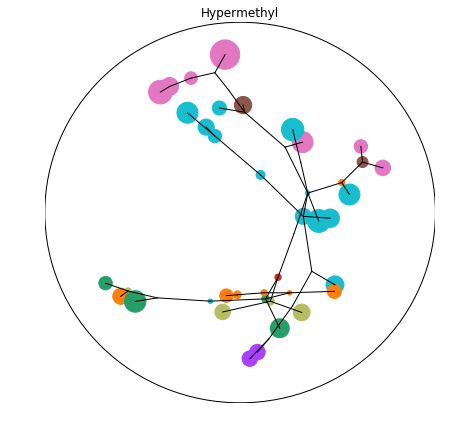

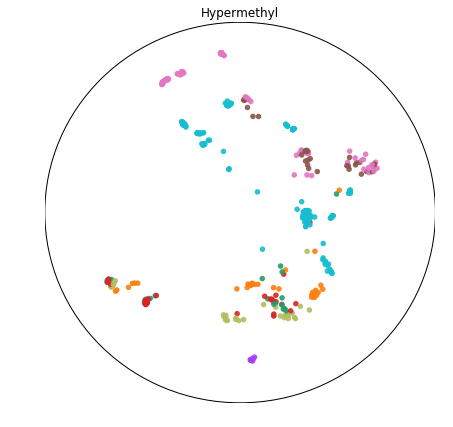

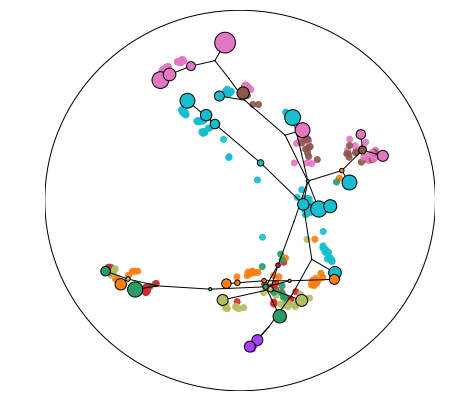

In [177]:
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
s = [20*len(batch_nodes[i]) for i in range(len(emb))]
big_col = ["white" for i in range(len(emb))]
for i in range(len(emb)):
    dic = {}
    for j in batch_nodes[i]:
        if(colors[j[0]] not in dic):
            dic[colors[j[0]]] = 0
        dic[colors[j[0]]] += 1
    maxkey = ""
    maxval = -1
    for key, val in dic.items():
        if(val > maxval):
            maxkey = key
            maxval = val
    if(maxkey != ""):
        big_col[i] = maxkey
plt.title("Hypermethyl")
        
plt.scatter(*emb.T, s=s, c = big_col)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()
for k in range(len(edges)):
    n0 = edges[k][0]
    n1 = edges[k][1]
    x_line = [ emb[n0][0],  emb[n1][0] ]
    y_line = [ emb[n0][1],  emb[n1][1] ]
    plt.plot(x_line, y_line, 'black', linewidth = 1)

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
plt.title("Hypermethyl")
plt.scatter(embeddings[:, 0], embeddings[:,1], s=20, cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
s = [10*len(batch_nodes[i]) for i in range(len(emb))]
big_col = ["white" for i in range(len(emb))]
for i in range(len(emb)):
    dic_node = {}
    for j in batch_nodes[i]:
        if(colors[j[0]] not in dic_node):
            dic_node[colors[j[0]]] = 0
        dic_node[colors[j[0]]] += 1
    maxkey = ""
    maxval = -1
    for key, val in dic_node.items():
        if(val > maxval):
            maxkey = key
            maxval = val
    if(maxkey != ""):
        big_col[i] = maxkey
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))

for k in range(len(edges)):
    n0 = edges[k][0]
    n1 = edges[k][1]
    x_line = [ emb[n0][0],  emb[n1][0] ]
    y_line = [ emb[n0][1],  emb[n1][1] ]
    plt.plot(x_line, y_line, 'black', linewidth = 1, zorder = 1)
plt.scatter(embeddings[:, 0], embeddings[:,1], cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.scatter(*emb.T, s=s, c = big_col, edgecolors='black', zorder=2)

In [178]:
def avg_distortion(p_x, x, tau):
    Dold = distance_matrix(x)
    Dnew = hypmetric(p_x, 1/tau)
    n = len(Dnew)
    d = 0
    for i in range(n):
        for j in range(i):
            d += abs(Dnew[i][j]-Dold[i][j])/Dold[i][j]
    
    return 2*d/(n*(n-1))

In [179]:
quality_measure(X, embeddings, tau = 0.05)
quality_measure(X, embX, tau = 0.05)

average distortion:  0.35752233318360566
MAP:  0.7117241272360432
average distortion:  0.33702269530144463
MAP:  0.6835465609643099


(0.33702269530144463, 0.6835465609643099)

In [140]:
dic_pickle = {}
dic_pickle['pg_node'] = emb
dic_pickle['pg_edges'] = edges
dic_pickle['embedding'] = embeddings
dic_pickle['scale'] = 0.05
dic_pickle['batch_nodes'] = batch_nodes
pickle.dump(dic_pickle, open("Embeddings/immune/hypermethyl.pkl", "wb" ))

In [5]:
data_dictionary = pickle.load(open("dnam/processed_ciber.pkl", "rb" ))
methyl_data = data_dictionary['methylation']
labels = data_dictionary['disease']

In [6]:
methyl_data, labels, colors, dic = preprocess_data(methyl_data, labels)

All Labels: primary site: digestive_system, primary site: urogenital_system, primary site: blood, primary site: nervous_system, primary site: thyroid, primary site: aero_digestive_tract, primary site: bone, primary site: breast, primary site: kidney, primary site: soft_tissue, primary site: skin, primary site: pancreas, cosmic_id: NA, primary site: lung


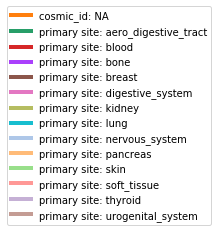

In [7]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
S = list(dic)
legend_elements = [Line2D([0], [0], color=dic[S[i]], lw=4, label=S[i]) for i in range(len(S))]

# Create the figure
fig, ax = plt.subplots(1, figsize=(2, 4))
plt.setp(ax, xticks=[], yticks=[])
ax.axis('off')
ax.legend(handles=legend_elements, loc='center')
#plt.show()

In [8]:
X = PCA(n_components=100).fit_transform(methyl_data)

In [138]:
d = elastic_graph(X, n_clusters = 60, a = 1e-3)
edges = d['edges']
node_positions = d['node_positions']

In [146]:
emb, embX, batch_nodes = testembedding(X, node_positions, edges, tau = 0.03)

Max degree:  5.0
Max Length:  225.1111452946286704
70 70
batch_size:  12
batch_size:  8
batch_size:  5
batch_size:  12
batch_size:  6
batch_size:  1
batch_size:  11
batch_size:  12
batch_size:  6
batch_size:  9
batch_size:  6
batch_size:  1
batch_size:  5
batch_size:  6
batch_size:  14
batch_size:  3
batch_size:  8
batch_size:  1
batch_size:  1
batch_size:  18
batch_size:  14
batch_size:  10
batch_size:  6
batch_size:  7
batch_size:  8
batch_size:  6
batch_size:  4
batch_size:  9
batch_size:  5
batch_size:  9
batch_size:  11
batch_size:  5
batch_size:  33
batch_size:  36
batch_size:  17
batch_size:  26
batch_size:  17
batch_size:  29
batch_size:  16
batch_size:  10
batch_size:  19
batch_size:  21
batch_size:  19
batch_size:  28
batch_size:  28
batch_size:  18
batch_size:  12
batch_size:  18
batch_size:  21
batch_size:  18
batch_size:  23
batch_size:  23
batch_size:  24
batch_size:  24
batch_size:  28
batch_size:  26
batch_size:  28
batch_size:  25
batch_size:  5
batch_size:  23
batch_s

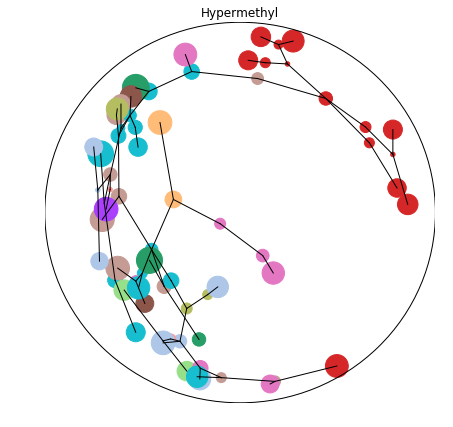

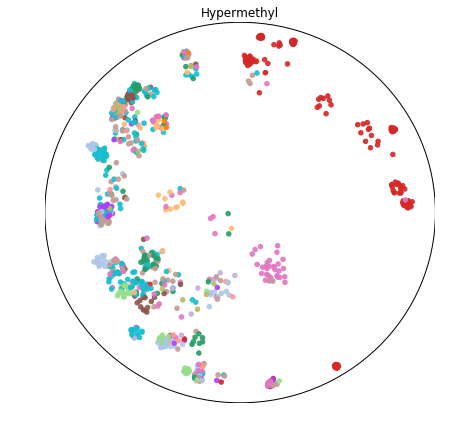

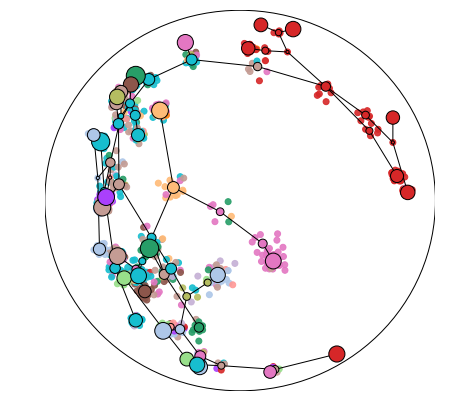

In [147]:
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
s = [20*len(batch_nodes[i]) for i in range(len(emb))]
big_col = ["white" for i in range(len(emb))]
for i in range(len(emb)):
    dic = {}
    for j in batch_nodes[i]:
        if(colors[j[0]] not in dic):
            dic[colors[j[0]]] = 0
        dic[colors[j[0]]] += 1
    maxkey = ""
    maxval = -1
    for key, val in dic.items():
        if(val > maxval):
            maxkey = key
            maxval = val
    if(maxkey != ""):
        big_col[i] = maxkey
plt.title("Hypermethyl")
        
plt.scatter(*emb.T, s=s, c = big_col)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()
for k in range(len(edges)):
    n0 = edges[k][0]
    n1 = edges[k][1]
    x_line = [ emb[n0][0],  emb[n1][0] ]
    y_line = [ emb[n0][1],  emb[n1][1] ]
    plt.plot(x_line, y_line, 'black', linewidth = 1)

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
plt.title("Hypermethyl")
plt.scatter(embX[:, 0], embX[:,1], s=20, cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
s = [10*len(batch_nodes[i]) for i in range(len(emb))]
big_col = ["white" for i in range(len(emb))]
for i in range(len(emb)):
    dic_node = {}
    for j in batch_nodes[i]:
        if(colors[j[0]] not in dic_node):
            dic_node[colors[j[0]]] = 0
        dic_node[colors[j[0]]] += 1
    maxkey = ""
    maxval = -1
    for key, val in dic_node.items():
        if(val > maxval):
            maxkey = key
            maxval = val
    if(maxkey != ""):
        big_col[i] = maxkey
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))

for k in range(len(edges)):
    n0 = edges[k][0]
    n1 = edges[k][1]
    x_line = [ emb[n0][0],  emb[n1][0] ]
    y_line = [ emb[n0][1],  emb[n1][1] ]
    plt.plot(x_line, y_line, 'black', linewidth = 1, zorder = 1)
plt.scatter(embX[:, 0], embX[:,1], cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.scatter(*emb.T, s=s, c = big_col, edgecolors='black', zorder=2)

In [148]:
emb = emb.astype('float64')
embX = embX.astype('float64')
embeddings = embX

In [149]:
closest_pnode = []
closest_X = []
for index in range(len(X)):
    closest_index = find_closest_nodes(embX[index], emb, 5)
    closest_pnode.append([emb[i] for i in closest_index])
    closest_X.append([node_positions[i] for i in closest_index])
    
KNN = kneighbors_graph(X, 10, mode='distance', metric='minkowski', include_self=False).toarray()
closest_index_points = []
for i in range(len(X)):
    closest_index_points.append(np.nonzero(np.array(KNN[i]))[0])
closest_index_points = np.array(closest_index_points)
print(closest_index_points)
'''
for i in range(20):
    embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 0.003, epochs = 3, tau = tau, alpha = 100, beta = 1e-5)
    embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 1e-3, epochs = 3, tau = tau, alpha = 0.01, beta = 0.1)
'''
embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 1e-2, epochs = 50, tau = 0.03, alpha = 10, beta = 1e-1)


[[  34   71  438 ...  807  830  928]
 [  55   83  103 ...  845  919 1010]
 [  27  199  202 ...  617  631  644]
 ...
 [  68   69   98 ...  738 1002 1027]
 [  34  164  177 ...  918  920  926]
 [  68   85   98 ...  524 1001 1025]]
Orginal Distance: tensor([[0.0531, 0.0977, 0.1897, 0.2888, 0.3706],
        [0.2175, 0.1450, 0.1864, 0.2187, 0.2324],
        [0.0607, 0.2126, 0.3892, 0.0730, 0.2645],
        ...,
        [0.0646, 0.2468, 0.1354, 0.2462, 0.3070],
        [0.1194, 0.1294, 0.1798, 0.3557, 0.2156],
        [0.0842, 0.2560, 0.3044, 0.1688, 0.1866]], dtype=torch.float64)
distloss: tensor(488.4425, dtype=torch.float64, grad_fn=<MulBackward0>)
maploss: tensor(1565.2537, dtype=torch.float64, grad_fn=<MulBackward0>)
loss tensor(2053.6962, dtype=torch.float64, grad_fn=<AddBackward0>)

distloss: tensor(437.7538, dtype=torch.float64, grad_fn=<MulBackward0>)
maploss: tensor(1340.9801, dtype=torch.float64, grad_fn=<MulBackward0>)
loss tensor(1778.7339, dtype=torch.float64, grad_fn=<AddBackwa

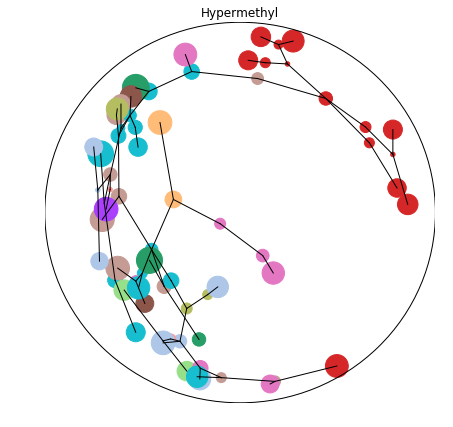

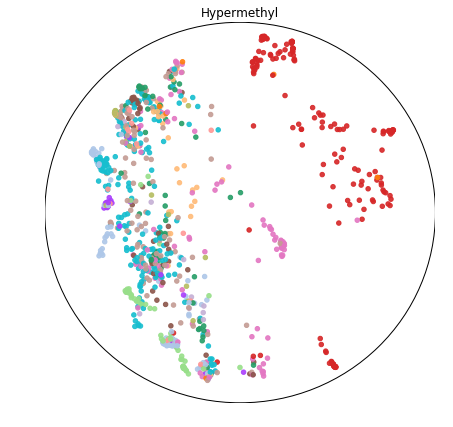

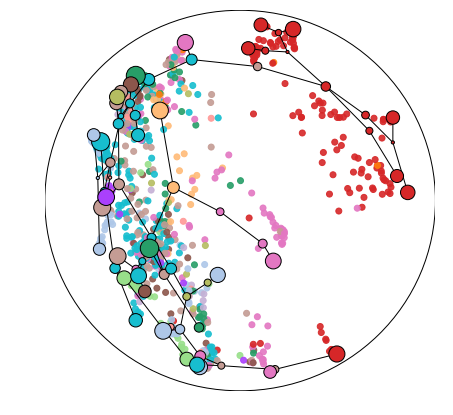

In [150]:
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
s = [20*len(batch_nodes[i]) for i in range(len(emb))]
big_col = ["white" for i in range(len(emb))]
for i in range(len(emb)):
    dic = {}
    for j in batch_nodes[i]:
        if(colors[j[0]] not in dic):
            dic[colors[j[0]]] = 0
        dic[colors[j[0]]] += 1
    maxkey = ""
    maxval = -1
    for key, val in dic.items():
        if(val > maxval):
            maxkey = key
            maxval = val
    if(maxkey != ""):
        big_col[i] = maxkey
plt.title("Hypermethyl")
        
plt.scatter(*emb.T, s=s, c = big_col)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()
for k in range(len(edges)):
    n0 = edges[k][0]
    n1 = edges[k][1]
    x_line = [ emb[n0][0],  emb[n1][0] ]
    y_line = [ emb[n0][1],  emb[n1][1] ]
    plt.plot(x_line, y_line, 'black', linewidth = 1)

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
plt.title("Hypermethyl")
plt.scatter(embeddings[:, 0], embeddings[:,1], s=20, cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
plt.plot()

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.axis('off')
s = [10*len(batch_nodes[i]) for i in range(len(emb))]
big_col = ["white" for i in range(len(emb))]
for i in range(len(emb)):
    dic_node = {}
    for j in batch_nodes[i]:
        if(colors[j[0]] not in dic_node):
            dic_node[colors[j[0]]] = 0
        dic_node[colors[j[0]]] += 1
    maxkey = ""
    maxval = -1
    for key, val in dic_node.items():
        if(val > maxval):
            maxkey = key
            maxval = val
    if(maxkey != ""):
        big_col[i] = maxkey
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))

for k in range(len(edges)):
    n0 = edges[k][0]
    n1 = edges[k][1]
    x_line = [ emb[n0][0],  emb[n1][0] ]
    y_line = [ emb[n0][1],  emb[n1][1] ]
    plt.plot(x_line, y_line, 'black', linewidth = 1, zorder = 1)
plt.scatter(embeddings[:, 0], embeddings[:,1], cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
plt.scatter(*emb.T, s=s, c = big_col, edgecolors='black', zorder=2)

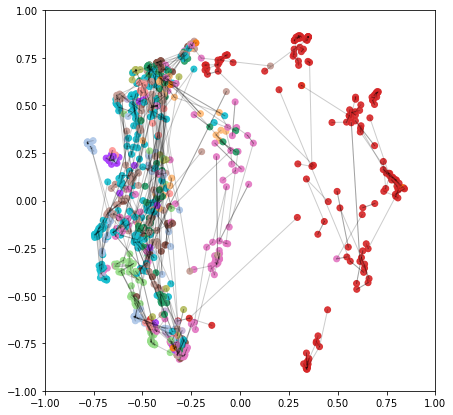

In [102]:
fig, ax = plt.subplots(1, figsize=(7, 7))
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 3, fill=False, edgecolor="black"))
KNN = kneighbors_graph(X, 1, mode='distance', metric='minkowski', include_self=False).toarray()
closest_index_points = []
for i in range(len(X)):
    closest_index_points.append(np.nonzero(np.array(KNN[i]))[0])
closest_index_points = np.array(closest_index_points)
for n0 in range(len(X)):
    for n1 in closest_index_points[n0]:
        x_line = [ embeddings[n0][0],  embeddings[n1][0] ]
        y_line = [ embeddings[n0][1],  embeddings[n1][1] ]
        plt.plot(x_line, y_line, 'black', linewidth = 1, zorder = 1, alpha = 0.2)
plt.scatter(embeddings[:, 0], embeddings[:,1], cmap='Spectral', c= colors, linewidth = 1, alpha = 0.9)
#plt.scatter(*emb.T, s=s, c = big_col, edgecolors='black', zorder=2)

{'#17becf', '#c5b0d5', '#e377c2', '#ff9896', '#279e68', '#d62728', '#aa40fc', '#c49c94', '#8c564b', '#ffbb78', '#aec7e8', '#98df8a', '#b5bd61', '#ff7f0e'}


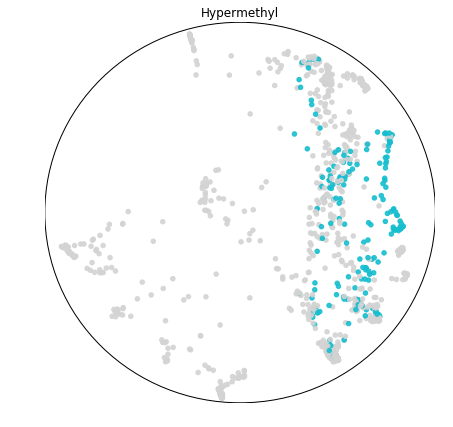

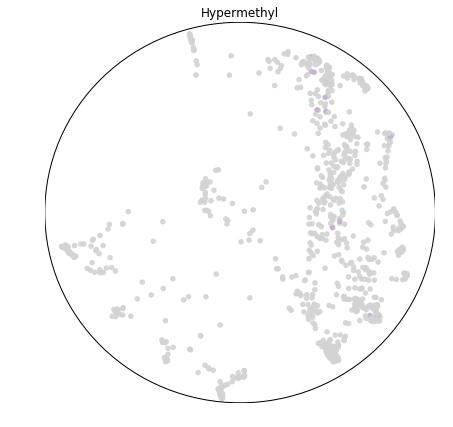

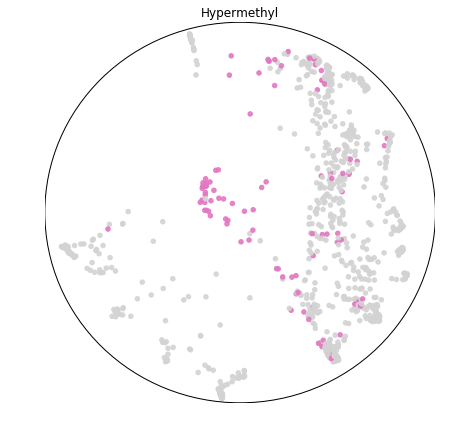

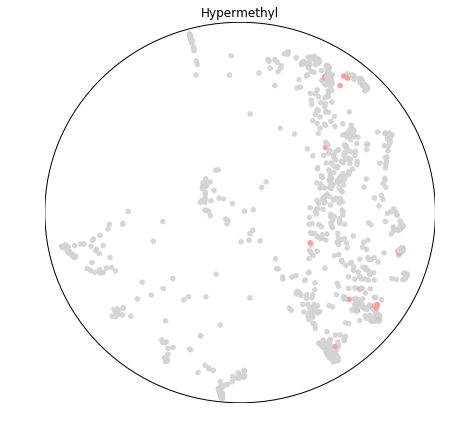

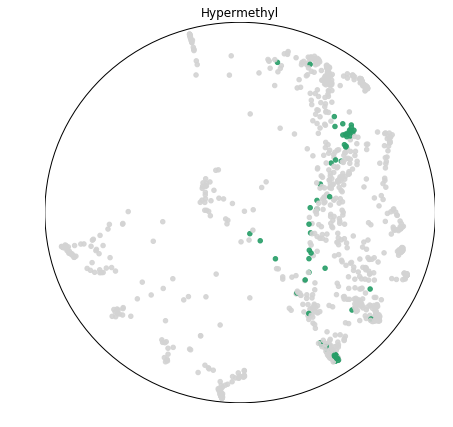

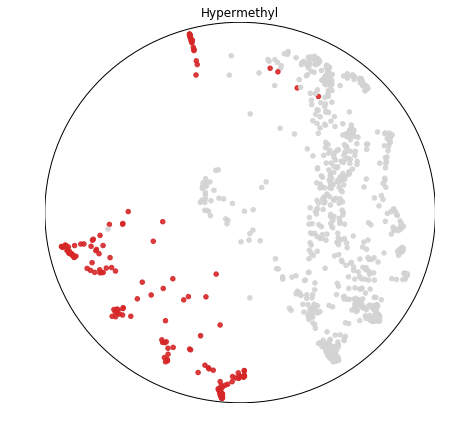

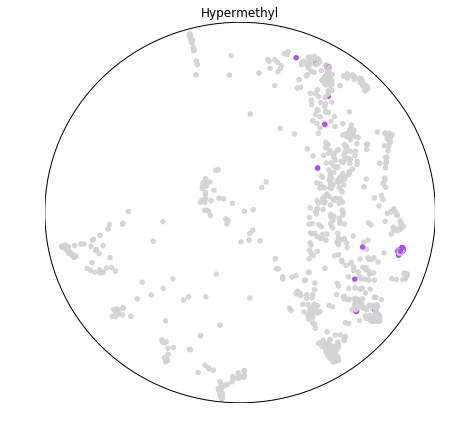

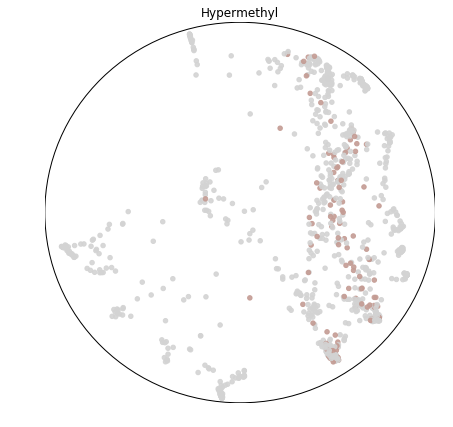

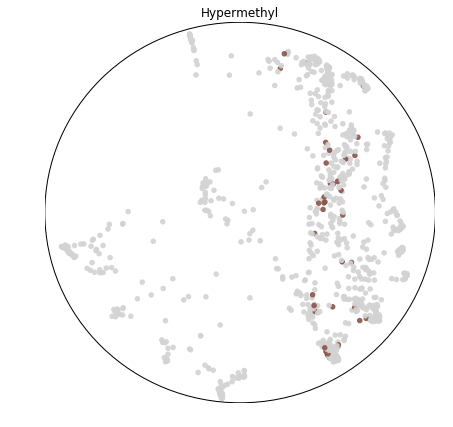

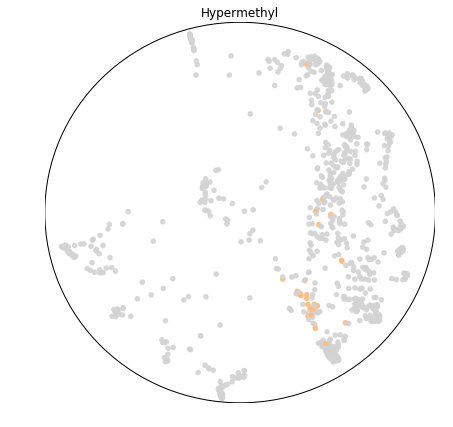

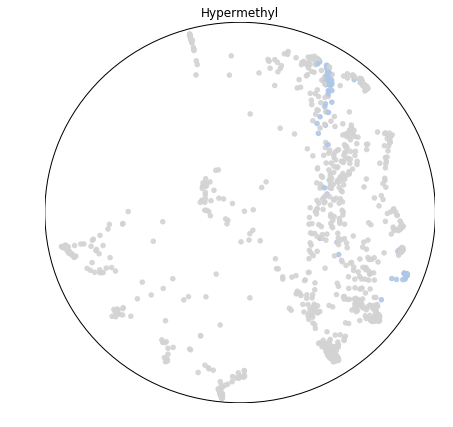

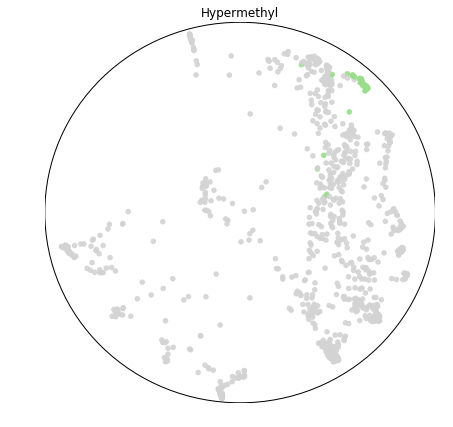

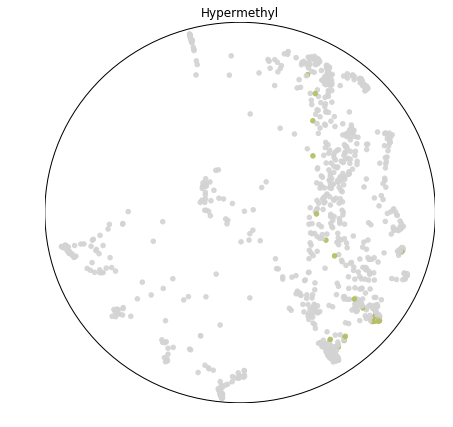

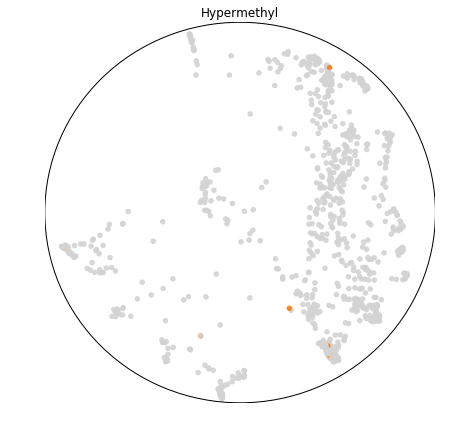

In [136]:
set_colors = set()
for i in colors:
    set_colors.add(i)
print(set_colors)
for col in set_colors:
    spec_colors = colors.copy()
    for i in range(len(spec_colors)):
        if(spec_colors[i] != col):
            spec_colors[i] = "#D3D3D3"
    fig, ax = plt.subplots(1, figsize=(7, 7))
    ax.axis('off')
    plt.title("Hypermethyl")
    plt.scatter(embeddings[:, 0], embeddings[:,1], s=20, cmap='Spectral', c= spec_colors, linewidth = 1, alpha = 0.9)
    plt.gca().set_xlim(-1, 1)
    plt.gca().set_ylim(-1, 1)
    plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))
    plt.plot()





In [137]:
quality_measure(X, embeddings, tau = 0.04)
quality_measure(X, embX, tau = 0.04)

average distortion:  0.5442819837186742
MAP:  0.48786734176478846
average distortion:  0.406051417605379
MAP:  0.4576359986522508


(0.406051417605379, 0.4576359986522508)

In [5]:
def hyperbolic(x, y):
    return math.acosh(1 + (2 * np.linalg.norm(x-y)**2 / ((1 - np.linalg.norm(x)**2)*(1 - np.linalg.norm(y)**2))))
def hypmetric(feature, tau):
    n_samples = len(feature)
    D = np.ndarray(shape = (n_samples, n_samples))
    for i in range(len(D)):
        for j in range(len(D)):
            D[i][j] = tau*hyperbolic(feature[i], feature[j])
    return D
def distance_matrix(X):
    return pairwise_distances(X, metric='minkowski')

In [69]:
hypmetric(new_x, 1)

array([[0.        , 1.32823027, 0.53046386, 1.5447208 ],
       [1.32823027, 0.        , 0.79776651, 0.21649053],
       [0.53046386, 0.79776651, 0.        , 1.01425703],
       [1.5447208 , 0.21649053, 1.01425703, 0.        ]])

In [20]:
arr = np.random.randn(10, 10)

In [21]:
H = distance_matrix(arr)

In [22]:
new_x = gans_to_poincare(h_mds(H, 2, len(H), 1e-3))

	 0 1437.4734093844295
		 1.0
	 Done with eigenvalue 0 at iteration 2 at abs_tol=0.07752077341115182 rel_tol=4.763845510218318e-05
	 0 403.740735812741
		 1.0
	 Done with eigenvalue 1 at iteration 3 at abs_tol=0.008671223788269344 rel_tol=5.328683544198298e-06
usM_pos: [[-0.31509634 -0.31508238]
 [-0.36584111 -0.36585792]
 [-0.32946621 -0.32945491]
 [-0.2662192  -0.26621267]
 [-0.29841255 -0.29841836]
 [-0.29967617 -0.29967725]
 [-0.36020058 -0.36019913]
 [-0.2774714  -0.27747321]
 [-0.32612838 -0.32613441]
 [-0.30903644 -0.30903549]]
lambdasM_pos: [-40.33947433 -40.33947435]
diag: [] 0


In [19]:
print(H)

[[ 0.         13.4517815  14.18878067 13.01159293 12.33241936 14.47250293
  13.7286049  12.92578237 11.94790877 13.33981563]
 [13.4517815   0.         13.93857947 14.12194248 13.39520233 14.19940457
  15.02123927 13.21332452 13.47660918 12.17893243]
 [14.18878067 13.93857947  0.         15.06986576 13.77950768 12.74466695
  14.2258668  13.32457924 14.73598028 13.72498798]
 [13.01159293 14.12194248 15.06986576  0.         13.63564764 15.33332552
  16.24106293 12.93455776 13.39593597 14.25092761]
 [12.33241936 13.39520233 13.77950768 13.63564764  0.         15.11940995
  14.11767975 13.51715064 12.63620743 12.10809049]
 [14.47250293 14.19940457 12.74466695 15.33332552 15.11940995  0.
  14.61614521 13.52043971 14.31949328 14.52948772]
 [13.7286049  15.02123927 14.2258668  16.24106293 14.11767975 14.61614521
   0.         14.27458324 15.51902526 14.68490107]
 [12.92578237 13.21332452 13.32457924 12.93455776 13.51715064 13.52043971
  14.27458324  0.         14.20064498 12.43306311]
 [11.947

In [5]:
def make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] ):
    X_noiseless = np.zeros((0,n_features))
    y_final = np.zeros(0)
    for layer in range(n_layers):
        current_label = 0 
        X = np.zeros((n_samples4base, n_features))
        X[:,0] = np.arange(n_samples4base)
        y = current_label * np.ones( n_samples4base )
        v_last_base_point_save = X[-1,:].copy()
        v_first_base_point_save = X[0,:].copy()

        # Make branches
        n_branches = len ( n_samples4branches )
        for c_branch in range( n_branches ) : # n_branches
            n_sample4branch = n_samples4branches[c_branch]
            current_label += 1
            y_branch = current_label * np.ones( n_sample4branch )
            angle = angles[c_branch] 
            if c_branch < n_branches/ 2:
                v_initial = v_last_base_point_save
            else:
                v_initial = v_first_base_point_save  
            X_branch = np.zeros( (n_sample4branch,  n_features)  ) #  [:2] = (np.cos(angle), np.sin(angle) )  
            v_direction = np.zeros( n_features)
            v_direction[0] = np.cos(angle)
            v_direction[1] = np.sin(angle)
            X_branch += v_direction # Broadcast vector to the whole array over axis 0 
            X_branch *= np.arange( 1, X_branch.shape[0] +1 ).reshape(X_branch.shape[0], 1 ) # Broadcast - mutiply each column by  by column = 1,2,3, ... 
            X_branch += v_initial # 
            X = np.concatenate( (X,X_branch) , axis = 0 )
            y = np.concatenate( (y, y_branch ))
        X_noiseless = np.concatenate( (X_noiseless,X) , axis = 0 )
        y_final = np.concatenate( (y_final,y) ) 

    X_noisy = X_noiseless + sigma_noise * np.random.randn( X_noiseless.shape[0], X_noiseless.shape[1] )


    y = y_final
    X = X_noisy

    return X,y

In [120]:
X,y = make_dumbbell(n_layers = 1, n_features = 100,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4])
n_clusters_max_elpi = 40
total_count = 0

In [14]:
def train(x, y, u, v, lr = 1e-3, epochs = 50, tau = 0.02):
    x = torch.tensor(x)
    y = torch.tensor(y)
    u = torch.tensor(u)
    v = torch.tensor(v)
    og_dist = create_prob(eucdist(v, y) * tau)
    min_u = [1e10, [0, 0]]
    for i in range(10):
        rand_u = u + torch.rand(2) * 1e-10
        rand_u.requires_grad_()
        loss = 0
        for t in range(5):
            y_pred = create_prob(pdist(rand_u, x))
            loss = lossfn(y_pred, og_dist)
            loss.backward()
            with torch.no_grad():
                d_p = poincare_grad(rand_u, rand_u.grad)
                rand_u -= lr * d_p * 10
                rand_u = torch.clamp(u, -1 + 1e-8, 1 - 1e-8)
                rand_u.requires_grad_()
            rand_u.grad = None
        loss = loss.item()
        if(loss < min_u[0]):
            min_u = [loss, rand_u]
    u = min_u[1]
    u.requires_grad_()
    

    
    print("Orginal Distance:", og_dist)
    for t in range(epochs):
        y_pred = create_prob(pdist(u, x))
        #print("y_pred:", y_pred)
        loss = lossfn(y_pred, og_dist)
        #print("loss:", loss)
        loss.backward()
        with torch.no_grad():
            d_p = poincare_grad(u, u.grad)
            u -= lr * d_p
            u = torch.clamp(u, -1 + 1e-8, 1 - 1e-8)
            #print("u:", u)
            u.requires_grad_()
        u.grad = None
    print("pdist:", create_prob(pdist(u, x)))
    print("loss:", loss)
    return u.detach().numpy()


In [121]:
d = elastic_graph(X, n_clusters = 20)
edges = d['edges']
node_positions = d['node_positions']

In [122]:
tau = 0.01
emb, embX, batch_nodes = embedding(X, node_positions, edges, tau)

Max degree:  3.0
Max Length:  322.38630322979668108


In [124]:
emb = emb.astype('float64')
embX = embX.astype('float64')

In [10]:
embeddings = np.zeros(embX.shape)
for index in range(len(X)):
    closest_index = find_closest_nodes(embX[index], emb, 3)
    closest_pnode = [emb[i] for i in closest_index]
    closest_X = [node_positions[i] for i in closest_index] 
    u = train(x = closest_pnode, y = closest_X, u = closest_pnode[0], v = X[index], lr = 1, epochs = 50, tau = tau)
    #print(u)
    embeddings[index] = u

Orginal Distance: tensor([0.3221, 0.3337, 0.3443], dtype=torch.float64)
pdist: tensor([0.2817, 0.3364, 0.3819], dtype=torch.float64, grad_fn=<CopySlices>)
loss: tensor(0.0069, dtype=torch.float64, grad_fn=<SumBackward0>)
Orginal Distance: tensor([0.3205, 0.3257, 0.3538], dtype=torch.float64)
pdist: tensor([0.3205, 0.3257, 0.3538], dtype=torch.float64, grad_fn=<CopySlices>)
loss: tensor(6.3330e-12, dtype=torch.float64, grad_fn=<SumBackward0>)
Orginal Distance: tensor([0.3187, 0.3524, 0.3289], dtype=torch.float64)
pdist: tensor([0.2768, 0.3912, 0.3320], dtype=torch.float64, grad_fn=<CopySlices>)
loss: tensor(0.0074, dtype=torch.float64, grad_fn=<SumBackward0>)
Orginal Distance: tensor([0.3203, 0.3318, 0.3479], dtype=torch.float64)
pdist: tensor([0.2882, 0.3455, 0.3664], dtype=torch.float64, grad_fn=<CopySlices>)
loss: tensor(0.0047, dtype=torch.float64, grad_fn=<SumBackward0>)
Orginal Distance: tensor([0.3190, 0.3317, 0.3493], dtype=torch.float64)
pdist: tensor([0.2766, 0.3357, 0.3877], 

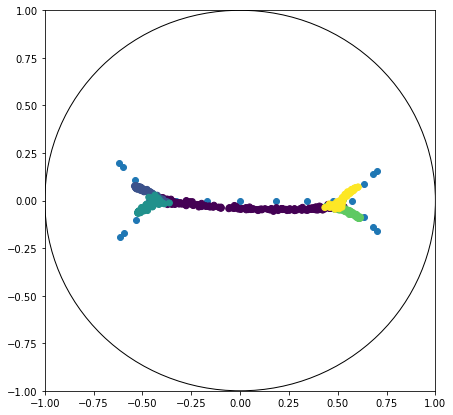

In [129]:
plt.figure(figsize=(7, 7))
plt.scatter(*emb.T, cmap = 'black')
plt.scatter(*embeddings.T, c=y)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))

In [130]:
quality_measure(X, embX, tau = 0.01)
quality_measure(X, embeddings, tau = 0.01)

average distortion:  0.36950899463435066
MAP:  0.5857477709837273
average distortion:  0.5191347805273002
MAP:  0.5791832926224286


(0.5191347805273002, 0.5791832926224286)

In [57]:
index = 0
closest_index = find_closest_nodes(embX[index], emb, 1)
closest_pnode = [emb[i] for i in closest_index]
closest_X = [node_positions[i] for i in closest_index] 
print(index, closest_pnode)
#print(closest_X)
#print(closest_index)
u = train(x = closest_pnode, y = closest_X, u = closest_pnode[0], v = X[index], lr = 0.1, tau = tau)
print(u)
#embeddings[index] = u

0 [array([7.83078978e-01, 8.91777453e-17])]
Orginal Distance: tensor([1.5374], dtype=torch.float64)
pdist: tensor([1.5374], dtype=torch.float64, grad_fn=<LogBackward>)
loss: tensor(8.4716e-10, dtype=torch.float64, grad_fn=<SumBackward0>)
[0.93775298 0.08633899]


In [65]:
torch.rand(1) * 1e-10

tensor([8.9161e-11])

In [33]:
test = torch.tensor([0.0, 0.0])
test += torch.rand(2)* 1e-8
test

tensor([8.0417e-09, 2.6533e-09])

In [125]:
embeddings = np.zeros(embX.shape)
closest_pnode = []
closest_X = []
for index in range(len(X)):
    closest_index = find_closest_nodes(embX[index], emb, 3)
    closest_pnode.append([emb[i] for i in closest_index])
    closest_X.append([node_positions[i] for i in closest_index])
    
KNN = kneighbors_graph(X, 5, mode='distance', metric='minkowski', include_self=False).toarray()
closest_index_points = []
for i in range(len(X)):
    closest_index_points.append(np.nonzero(np.array(KNN[i]))[0])
closest_index_points = np.array(closest_index_points)
print(closest_index_points)
embeddings = embX
'''
for i in range(20):
    embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 0.003, epochs = 3, tau = tau, alpha = 100, beta = 1e-5)
    embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 1e-3, epochs = 3, tau = tau, alpha = 0.01, beta = 0.1)
'''
embeddings = train2(x = closest_pnode, y = closest_X, u = embeddings,
                        v = X, clos_index = closest_index_points, lr = 0.01, epochs = 30, tau = tau, alpha = 10, beta = 0.01)


[[ 11 411 425 500 504]
 [415 450 451 500 505]
 [  9 415 500 515 523]
 ...
 [576 583 584 585 589]
 [570 583 589 594 596]
 [564 587 589 596 598]]
Orginal Distance: tensor([[0.3247, 0.3310, 0.3443],
        [0.3201, 0.3366, 0.3432],
        [0.3299, 0.3346, 0.3355],
        ...,
        [0.3112, 0.3225, 0.3663],
        [0.3149, 0.3239, 0.3613],
        [0.3109, 0.3221, 0.3670]], dtype=torch.float64)
tensor([[0.1396, 0.1844, 0.2234, 0.1435, 0.1394],
        [0.4529, 0.2097, 0.2748, 0.1807, 0.1929],
        [0.3400, 0.3330, 0.1026, 0.1888, 0.0943],
        ...,
        [0.1820, 0.1367, 0.0585, 0.0409, 0.0753],
        [0.0591, 0.1501, 0.0934, 0.1629, 0.1081],
        [0.1982, 0.1798, 0.1977, 0.1980, 0.1565]], dtype=torch.float64,
       grad_fn=<StackBackward>)
tensor([[1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08],
        [1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08],
        [1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08],
        ...,
        [

KeyboardInterrupt: 

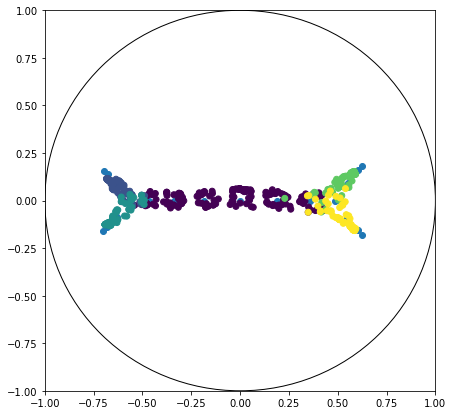

In [98]:
plt.figure(figsize=(7, 7))
plt.scatter(*emb.T, cmap = 'black')
plt.scatter(*embeddings.T, c=y)
plt.gca().set_xlim(-1, 1)
plt.gca().set_ylim(-1, 1)
plt.gca().add_artist(plt.Circle((0, 0), 1, fill=False, edgecolor="black"))

In [99]:
quality_measure(X, embeddings, tau = 0.01)
quality_measure(X, embX, tau = 0.01)


average distortion:  0.40149678016949186
MAP:  0.6011357608577551
average distortion:  0.3703250808448477
MAP:  0.5759004545317745


(0.3703250808448477, 0.5759004545317745)

In [41]:
test = torch.tensor([[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]])
D = [[0.1, 0.2, 0.2], [0.2, 2.0, 0.3], [3, 1, 3], [2, 1, 2]]
arr = [[D[test[i][j]] for j in range(len(test[i]))]for i in range(len(test))]
print(torch.tensor(arr))

tensor([[[0.2000, 2.0000, 0.3000],
         [3.0000, 1.0000, 3.0000],
         [2.0000, 1.0000, 2.0000]],

        [[0.1000, 0.2000, 0.2000],
         [3.0000, 1.0000, 3.0000],
         [2.0000, 1.0000, 2.0000]],

        [[0.1000, 0.2000, 0.2000],
         [0.2000, 2.0000, 0.3000],
         [2.0000, 1.0000, 2.0000]],

        [[0.1000, 0.2000, 0.2000],
         [0.2000, 2.0000, 0.3000],
         [3.0000, 1.0000, 3.0000]]])


In [32]:
torch.sum(test, dim = -1)

tensor([[0.2104, 0.1060, 0.3197],
        [0.2104, 0.3197, 0.1060]])

In [62]:
from sklearn.neighbors import kneighbors_graph

In [63]:
KNN = kneighbors_graph(X, 5, mode='distance', metric='minkowski', include_self=False).toarray()

In [72]:
closest_index_points = []
for i in range(len(X)):
    closest_index_points.append(np.nonzero(np.array(KNN[i]))[0])
print(np.array(closest_index_points))

[[  2  10  14  74 505]
 [ 16  23 414 509 540]
 [ 15  16  43  51 414]
 ...
 [571 574 586 590 596]
 [542 546 578 585 586]
 [543 568 574 586 592]]


In [19]:
np.array([np.random.randint(5) for i in range(5)])


array([3, 4, 1, 0, 3])